# Hyper parameter analysis

- independent vars:
    - algorithm
        - population
        - generations
        - number of mutations
        - crossover strategy
        - crossover rounds
        - selection quantile
        - gd rounds
    - journey params
        - journey direction
        - speed
        - time
        - hazards ignored
- dependent vars
    - cost
    - route length (resulting average speed over ground)
    - runtime
    - length

In [2]:
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from load_tuning_results import (
    load_results_raw,
    load_result_for_key,
    add_derived_features,
    filter_suspicious_routes,
)

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
gdf = gpd.read_parquet("../results/results_prelim.geoparquet")
gdf = add_derived_features(gdf)
gdf

,hyper_population_size,hyper_random_seed,hyper_selection_acceptance_rate_warmup,hyper_mutation_width_fraction_warmup,hyper_mutation_displacement_fraction_warmup,hyper_generations,hyper_offspring_size,hyper_crossover_rounds,hyper_selection_quantile,hyper_selection_acceptance_rate,...,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative,geometry,hyper_num_individuals,journey_duration,seed_cost,elite_speed_og_mps_average
filename,,,,,,,,,,,,,,,,,,,,,
result:0008:seed2010129258,256,2010129258,0.3,0.99,0.25,1,4,2,0.25,0.00,...,0,6.108673e+06,1.002516,7.209229e+12,0.904939,"LINESTRING (-11 50, -12.84149 50.11149, -14.73...",256,11 days 10:10:42,7.966538e+12,6.188869
result:0008:seed2010129258,256,2010129258,0.3,0.99,0.25,1,4,2,0.25,0.00,...,1,6.108673e+06,1.002516,7.209229e+12,0.904939,"LINESTRING (-11 50, -12.84149 50.11149, -14.73...",256,11 days 10:10:42,7.966538e+12,6.188869
result:0012:seed642567293,256,642567293,0.3,0.99,0.25,1,4,2,0.10,0.25,...,0,6.544757e+06,1.074083,6.099380e+12,0.873315,"LINESTRING (-11 50, -12.88958 50.06153, -14.71...",256,11 days 10:10:42,6.984166e+12,6.630678
result:0012:seed642567293,256,642567293,0.3,0.99,0.25,1,4,2,0.10,0.25,...,1,6.544757e+06,1.074083,6.099380e+12,0.873315,"LINESTRING (-11 50, -12.88958 50.06153, -14.71...",256,11 days 10:10:42,6.984166e+12,6.630678
result:0013:seed2157407743,128,2157407743,0.3,0.99,0.10,2,4,1,0.10,0.25,...,0,6.249119e+06,1.025565,5.228304e+12,0.874525,"LINESTRING (-80.5 30, -79.48249 30.81416, -78....",256,11 days 10:10:42,5.978451e+12,6.331158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result:1995:seed4150290824,128,4150290824,0.3,0.99,0.10,1,4,1,0.10,0.00,...,1,6.104592e+06,1.001846,6.984526e+12,0.865933,"LINESTRING (-80.5 30, -79.65854 30.68106, -78....",128,13 days 17:00:51,8.065893e+12,5.153942
result:1996:seed1200463295,128,1200463295,0.3,0.99,0.10,1,4,2,0.25,0.25,...,0,6.115988e+06,1.003716,5.957632e+12,0.976325,"LINESTRING (-80.5 30, -79.64782 30.67132, -78....",128,13 days 17:00:51,6.102098e+12,5.163564
result:1996:seed1200463295,128,1200463295,0.3,0.99,0.10,1,4,2,0.25,0.25,...,1,6.115988e+06,1.003716,5.957632e+12,0.976325,"LINESTRING (-80.5 30, -79.64782 30.67132, -78....",128,13 days 17:00:51,6.102098e+12,5.163564


<Axes: >

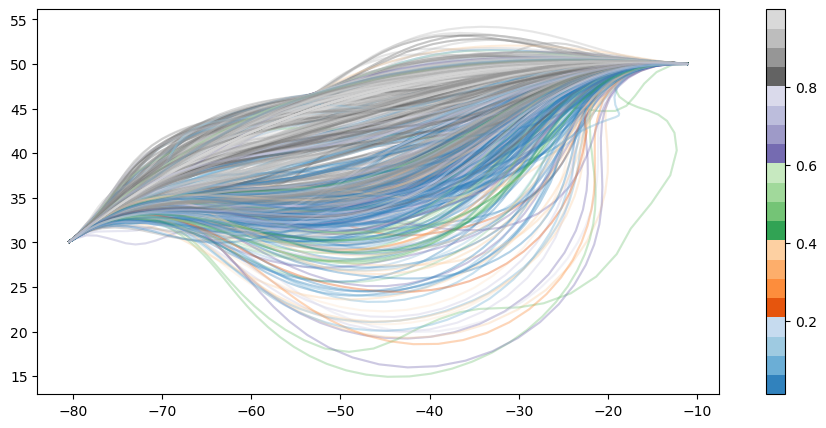

In [27]:
gdf.plot(column="elite_cost_relative", alpha=0.2, legend=True, cmap="tab20c", figsize=(12, 5))

In [7]:
gdf = filter_suspicious_routes(gdf)

0.45% suspicious routes


In [8]:
columns_independent_journey = [
    "journey_name",
    "journey_time_start",
    "journey_speed_knots",
]
values_independent_journey = gdf.loc[:, columns_independent_journey].apply(set, axis=0)
values_independent_journey

journey_name                       {Atlantic_backward, Atlantic_forward}
journey_time_start     {2021-09-01T00:00:00, 2021-08-01T00:00:00, 202...
journey_speed_knots                                    {8.0, 10.0, 12.0}
dtype: object

In [9]:
columns_independent_algo = [
    "hyper_population_size",
    "hyper_generations",
    "hyper_mutation_iterations",
    "hyper_crossover_strategy",
    # "hyper_crossover_rounds",
    # "hyper_selection_quantile",
]
values_independent_algo = gdf.loc[:, columns_independent_algo].apply(set, axis=0)
values_independent_algo

hyper_population_size                {256.0, 128.0}
hyper_generations                   {1.0, 2.0, 4.0}
hyper_mutation_iterations                {1.0, 3.0}
hyper_crossover_strategy     {random, minimal_cost}
dtype: object

In [10]:
columns_dependent = [
    "elite_length_meters",
    "elite_length_relative",
    "elite_cost_absolute",
    "elite_cost_relative",
    "elite_speed_og_mps_average",
    "runtime",
    "seed_cost",
]

In [11]:
df_filtered = (
    gdf.set_index(columns_independent_journey)
    .loc[pd.IndexSlice["Atlantic_forward", :, :]]
    .groupby(
        columns_independent_algo + ["hyper_ignore_hazards", "journey_speed_knots"]
    )[columns_dependent]
    .median()
    .reset_index()  # Convert back to regular DataFrame
)

# Now use relplot with different visual encodings
# sns.set_style("whitegrid")
sns.set_theme(
    context="paper",  # Scales fonts/elements for papers (vs 'notebook', 'talk', 'poster')
    style="whitegrid",  # Clean style with axis ticks (or 'white', 'whitegrid')
    palette="colorblind",  # Colorblind-friendly palette
    font_scale=1.1,  # Adjust if needed (1.0 is default for 'paper')
)
sns.relplot(
    data=df_filtered,
    x="hyper_generations",
    y="elite_cost_relative",
    hue="hyper_crossover_strategy",
    col="hyper_mutation_iterations",
    style="hyper_population_size",  # Create separate subplots for each population size
    row="hyper_ignore_hazards",
    size="journey_speed_knots",
    sizes=(1.5, 3),
    kind="line",
    markers=True,
    dashes=True,
    linewidth=2,
    markersize=7,
)

fig = plt.gcf()

fig.savefig("../figures/hyperparams_cost_rel_Atlantic_forward.pdf", dpi=200)
fig.savefig("../figures/hyperparams_cost_rel_Atlantic_forward.png", dpi=200)

KeyError: 'hyper_ignore_hazards'

In [12]:
df_filtered = (
    gdf.set_index(columns_independent_journey)
    .loc[pd.IndexSlice["Atlantic_forward", :, :]]
    .groupby(
        columns_independent_algo + ["hyper_ignore_hazards", "journey_speed_knots"]
    )[columns_dependent]
    .median()
    .reset_index()  # Convert back to regular DataFrame
)

# Now use relplot with different visual encodings
# sns.set_style("whitegrid")
sns.set_theme(
    context="paper",  # Scales fonts/elements for papers (vs 'notebook', 'talk', 'poster')
    style="whitegrid",  # Clean style with axis ticks (or 'white', 'whitegrid')
    palette="colorblind",  # Colorblind-friendly palette
    font_scale=1.1,  # Adjust if needed (1.0 is default for 'paper')
)

df_filtered["runtime_seconds"] = df_filtered.runtime.dt.total_seconds()

sns.relplot(
    data=df_filtered,
    x="hyper_generations",
    y="runtime_seconds",
    hue="hyper_crossover_strategy",
    col="hyper_mutation_iterations",
    style="hyper_population_size",  # Create separate subplots for each population size
    row="hyper_ignore_hazards",
    size="journey_speed_knots",
    sizes=(1.5, 3),
    kind="line",
    markers=True,
    dashes=True,
    linewidth=2,
    markersize=7,
)

fig = plt.gcf()

fig.savefig("../figures/hyperparams_runtime_Atlantic_forward.pdf", dpi=200)
fig.savefig("../figures/hyperparams_runtime_Atlantic_forward.png", dpi=200)

KeyError: 'hyper_ignore_hazards'

In [13]:
df_filtered = (
    gdf.set_index(columns_independent_journey)
    .loc[pd.IndexSlice["Atlantic_backward", :, :]]
    .groupby(
        columns_independent_algo + ["hyper_ignore_hazards", "journey_speed_knots"]
    )[columns_dependent]
    .median()
    .reset_index()  # Convert back to regular DataFrame
)

# Now use relplot with different visual encodings
# sns.set_style("whitegrid")
sns.set_theme(
    context="paper",  # Scales fonts/elements for papers (vs 'notebook', 'talk', 'poster')
    style="whitegrid",  # Clean style with axis ticks (or 'white', 'whitegrid')
    palette="colorblind",  # Colorblind-friendly palette
    font_scale=1.1,  # Adjust if needed (1.0 is default for 'paper')
)
sns.relplot(
    data=df_filtered,
    x="hyper_generations",
    y="elite_cost_relative",
    hue="hyper_crossover_strategy",
    col="hyper_mutation_iterations",
    style="hyper_population_size",  # Create separate subplots for each population size
    row="hyper_ignore_hazards",
    size="journey_speed_knots",
    sizes=(1.5, 3),
    kind="line",
    markers=True,
    dashes=True,
    linewidth=2,
    markersize=7,
)

fig = plt.gcf()

fig.savefig("../figures/hyperparams_cost_rel_Atlantic_backward.pdf", dpi=200)
fig.savefig("../figures/hyperparams_cost_rel_Atlantic_backward.png", dpi=200)

KeyError: 'hyper_ignore_hazards'

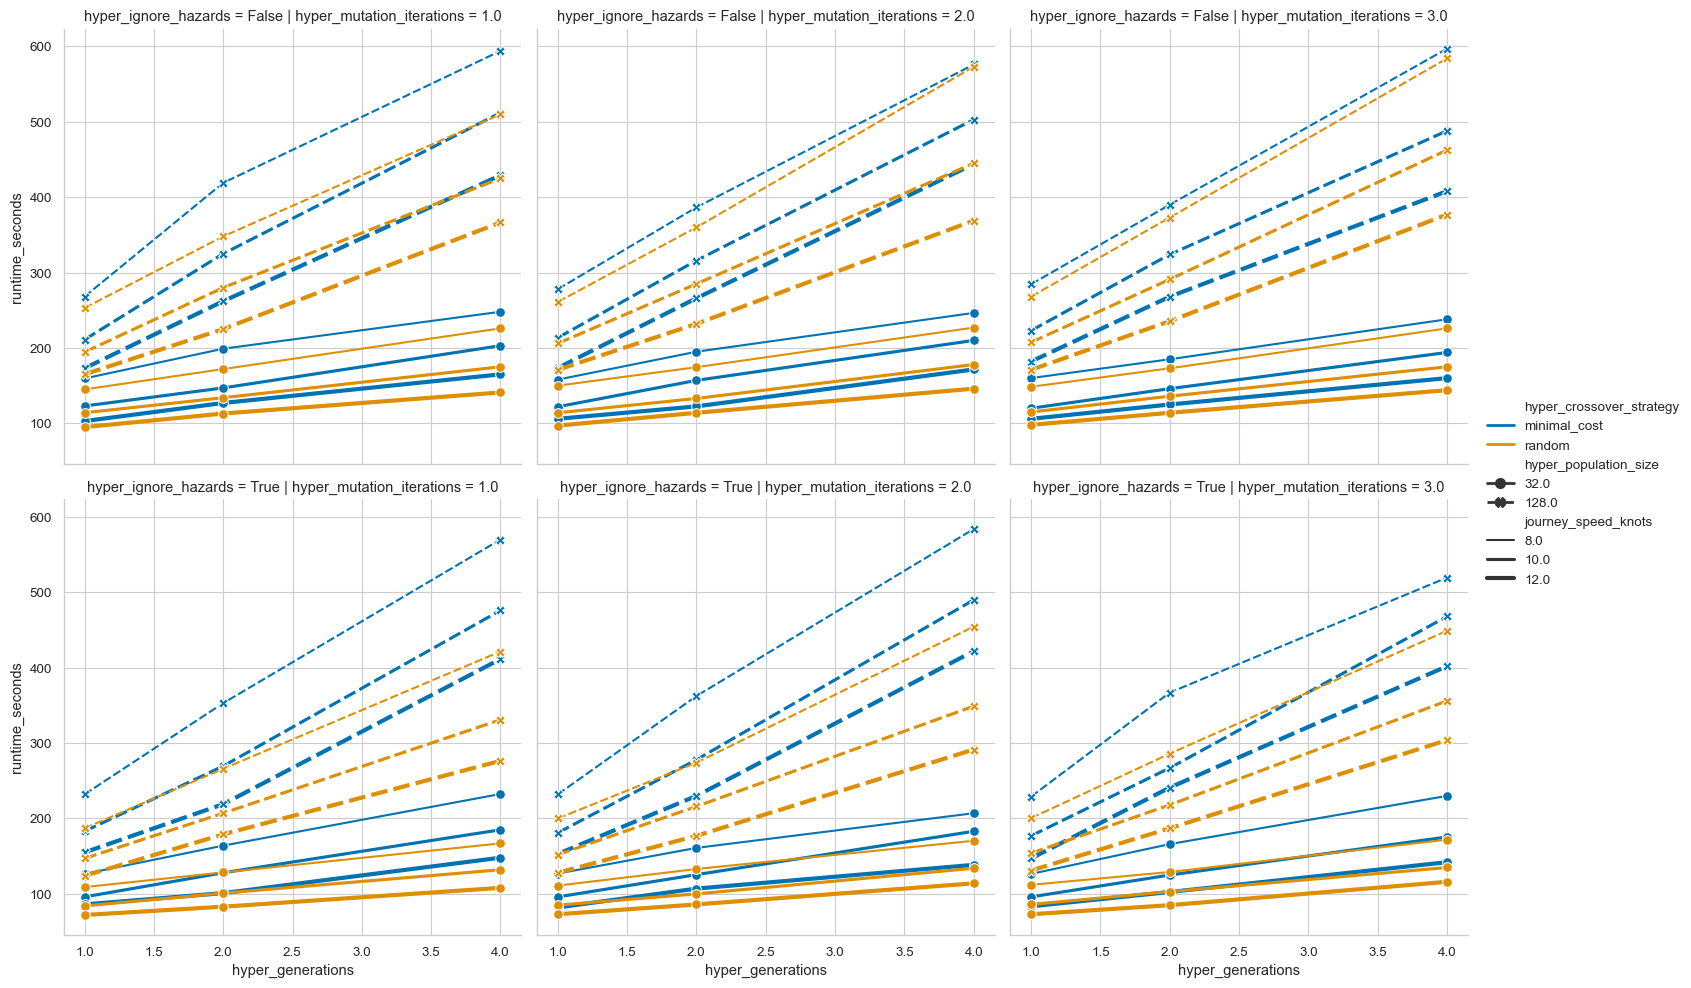

In [11]:
df_filtered = (
    gdf.set_index(columns_independent_journey)
    .loc[pd.IndexSlice["Atlantic_backward", :, :]]
    .groupby(
        columns_independent_algo + ["hyper_ignore_hazards", "journey_speed_knots"]
    )[columns_dependent]
    .median()
    .reset_index()  # Convert back to regular DataFrame
)

# Now use relplot with different visual encodings
# sns.set_style("whitegrid")
sns.set_theme(
    context="paper",  # Scales fonts/elements for papers (vs 'notebook', 'talk', 'poster')
    style="whitegrid",  # Clean style with axis ticks (or 'white', 'whitegrid')
    palette="colorblind",  # Colorblind-friendly palette
    font_scale=1.1,  # Adjust if needed (1.0 is default for 'paper')
)

df_filtered["runtime_seconds"] = df_filtered.runtime.dt.total_seconds()

sns.relplot(
    data=df_filtered,
    x="hyper_generations",
    y="runtime_seconds",
    hue="hyper_crossover_strategy",
    col="hyper_mutation_iterations",
    style="hyper_population_size",  # Create separate subplots for each population size
    row="hyper_ignore_hazards",
    size="journey_speed_knots",
    sizes=(1.5, 3),
    kind="line",
    markers=True,
    dashes=True,
    linewidth=2,
    markersize=7,
)

fig = plt.gcf()

fig.savefig("../figures/hyperparams_runtime_Atlantic_backward.pdf", dpi=200)
fig.savefig("../figures/hyperparams_runtime_Atlantic_backward.png", dpi=200)